In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
import multiprocessing  as mp
from itertools import product

from keras.models import Sequential,Model
from keras.layers import Dense, Input, Concatenate, Lambda,LSTM,Dropout,Layer,ConvLSTM2D
from keras.optimizers import RMSprop

from sys import getsizeof
import warnings

from functions import *

Using TensorFlow backend.


# Data import

In [2]:
startTime = 7*3600
endTime = 10*3600
dt = 30

Data = get_time_data('data/data2/Times/fahrzeiten_soll_ist_20200105_20200111.csv')
Data = Data.loc[Data['datum_nach'].dt.dayofweek < 5,:]

#delete depot run
Data = Data[~Data['fw_lang'].str.contains('DEP|Einfahrt|Ausfahrt')]
#Data=Data[(Data['soll_ab_nach']>startTime ) & (Data['soll_ab_nach']<endTime)] # only during peak hour (6am to 9 am)

#,'datum_nach','fahrzeug','soll_ab_nach'])

Studied_line = 32
connected = []

Stops = get_stops_data('data/data2/haltestelle.csv')
Stops_pos = get_stops_data('data/data2/haltepunkt.csv')

Line = get_line_data('data/data1/linie.csv')

Stops['Line'] = ""

Line['Connected'] = 0

for stop in Stops['halt_diva']:

    if any(Data.loc[Data['halt_diva_nach'] == stop ,'linie'].unique() == Studied_line):
        for l in [Data.loc[Data['halt_diva_nach'] == stop ,'linie'].unique()][0]:
            Line.loc[Line['Linienname'] == l,'Connected'] = 1
Line.loc[Studied_line,'Connected'] = 2

Stops_pos = Stops_pos[Stops_pos['halt_punkt_ist_aktiv']]
Stops_pos = Stops_pos.groupby(by = 'halt_id').mean()
Stops_pos = Stops_pos.merge(Stops[{'halt_id', 'halt_diva'}],left_on='halt_id',right_on='halt_id')

if all(Data.columns != 'Connected'):
    Data =  Data.merge(Line,left_on='linie',right_on='Linienname')
    Data =  Data.merge(Stops_pos[{'halt_diva','GPS_Latitude',
       'GPS_Longitude'}],left_on='halt_diva_nach',right_on='halt_diva')

## features selection but here we do not select features but stops


/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


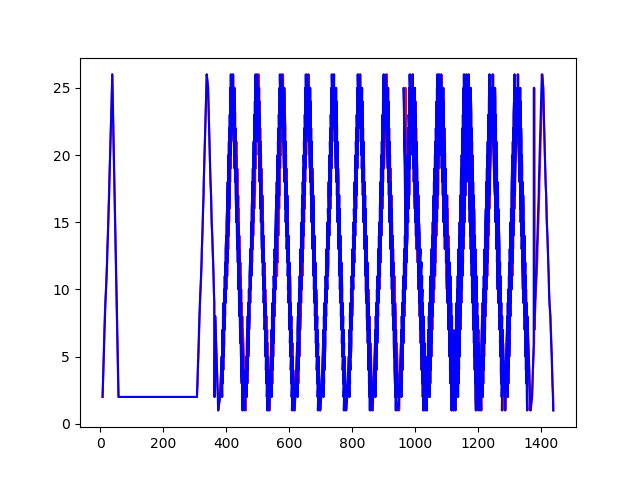

In [3]:
%matplotlib notebook

time_frame = 20*60 # we look at Xmin data frame
Bus_id = Data.loc[(Data['linie'] == Studied_line),'fahrzeug'].unique()[0]
Data_bus = Data[(Data['fahrzeug'] == Bus_id) & (Data['linie'] == Studied_line)]
Data_bus['Stop'] = (Data_bus['richtung']-1) * (max(Data_bus['seq_nach'])+1 - Data_bus['seq_nach']) - (Data_bus['richtung']-2) * Data_bus['seq_nach']
Data_bus = Data_bus.sort_values(by='ist_ab_von')

plt.plot(Data_bus['ist_ab_von']/60,Data_bus['Stop'],color = 'r')
plt.plot(Data_bus['soll_ab_von']/60,Data_bus['Stop'],color = 'b')

y_real = Data[Data['fahrzeug'] == Bus_id]# all the delays for one precise bus (ID = bus number)

#Features.groupby(['Line']).mean()

select = np.array(['Delta_stops','Delta_trip','Tot_lat','Is_connected','IsBus','IsTram','IsOther','Time','Dist','Lat','ID'])
#y_value =  Data[]

## Convert data to feed them in the neural network
In this section all the data are converted to have bus stops delays at any point in time. The idea is too look every dt, if there is a change we update, if not we keep the same value. The first iteration the last known position is kept. We extract the following data for each day ;

+ Increase in lateness due to boarding 
+ Increase in lateness due to travel time
+ Total lateness
+ If the line is connected to our line
+ the type of the line
+ the Time 
+ the distance to the studied vehicle 

Note that the data are shape is made x: time and y stops and then transposed, the process was much more faster ( more than 10x) because panda prefer to work with a lot of row than lots of columns

# NOTES TO MYSELF,
to win time on the change of type, transform T-B etc to float. same with is connected, should we had a 2 for is line ?

dt or each new studied bus arrival ? - does LSTM like having not regular time step ?

To check, Bus stay one the line whole time ?

In [4]:
select = np.array(['Delta_stops','Delta_trip','Tot_lat','Is_connected','IsBus','IsTram','IsOther','Time','Dist','Lat','ID'])

idx = pd.IndexSlice
ncoeur = 8
Data = Data.sort_values(by =['Linienname','halt_diva_nach'])

t1 = time.time()
BusPos = pd.DataFrame(columns = range(startTime,endTime,dt),index = ['Lat','Long'])
#FrameT = pd.DataFrame(index = range(startTime,endTime,dt),columns = range(Data['datum_nach'].unique().shape[0]))  & Data['datum_nach'] == d
#Colnames = [np.repeat(range(startTime,endTime,dt),11),np.resize(select,11*int((endTime-startTime)/dt))]

def Data_Selection(Data_day):

    Bus_id = Data_day.loc[(Data_day['linie'] == Studied_line) & (Data_day['soll_ab_nach'] ==25212),'fahrzeug'].values[0]

    Colnames = range(startTime,endTime,dt)
    
    RowNames = [np.repeat(10000*Data[{'Linienname','halt_diva_nach'}].drop_duplicates()['Linienname'] + Data[{'Linienname','halt_diva_nach'}].drop_duplicates()['halt_diva_nach'],11),
            np.resize(select,11*len(Data[{'Linienname','halt_diva_nach'}].drop_duplicates()))]
    FrameT = pd.DataFrame(index = RowNames,columns = Colnames)
    BusPos = pd.DataFrame(columns = range(startTime,endTime,dt),index = ['Lat','Long'])

    for t in range(startTime,endTime,dt):

        if t == startTime:
            # the first t is lower so we have the last known position 
            sel = 10000*Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),{'Linienname','halt_diva_nach'}].drop_duplicates()['Linienname']+Data_day.loc[(Data_day['ist_ab_nach']>t-4800 ) & (Data_day['ist_ab_nach']<t+dt),{'Linienname','halt_diva_nach'}].drop_duplicates()['halt_diva_nach']
            FrameT.loc[idx[sel,:],t] = pd.DataFrame(
                {'Delta_stops'  :(Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'ist_ab_nach']-Data_day.loc[(Data_day['ist_ab_nach']>t- 4800  ) & (Data_day['ist_ab_nach']<t+dt),'ist_an_nach1']-Data_day.loc[(Data_day['ist_ab_nach']>t- 4800  ) & (Data_day['ist_ab_nach']<t+dt),'soll_ab_nach']+Data_day.loc[(Data_day['ist_ab_nach']>t -4800) & (Data_day['ist_ab_nach']<t+dt),'soll_an_nach']),
                 'Delta_trip'   :Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'ist_an_nach1']-Data_day.loc[(Data_day['ist_ab_nach']>t- 4800  ) & (Data_day['ist_ab_nach']<t+dt),'ist_ab_von']-Data_day.loc[(Data_day['ist_ab_nach']>t- 4800  ) & (Data_day['ist_ab_nach']<t+dt),'soll_an_nach']+Data_day.loc[(Data_day['ist_ab_nach']>t -4800) & (Data_day['ist_ab_nach']<t+dt),'soll_ab_von'],
                 'Tot_lat'      :Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'ist_ab_nach']-Data_day.loc[(Data_day['ist_ab_nach']>t- 4800  ) & (Data_day['ist_ab_nach']<t+dt),'soll_ab_nach'],
                 'Is_connected' :Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'Connected'].values,
                 
                  'IsBus'        : ((Data_day.loc[(Data_day['ist_ab_nach']>t -4800) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values == 'B' )|(
                                   Data_day.loc[(Data_day['ist_ab_nach']>t -4800) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values == 'TB')).astype('float'),
            
                 'IsTram'       :(Data_day.loc[(Data_day['ist_ab_nach']>t -4800) & (Data_day['ist_ab_nach']<t+dt),'VSYS'] == 'T').astype('float'),
                 
                 'IsOther'      :((Data_day.loc[(Data_day['ist_ab_nach']>t -4800) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values != 'B' ) & (
                                  Data_day.loc[(Data_day['ist_ab_nach']>t -4800) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values != 'T') & (
                                  Data_day.loc[(Data_day['ist_ab_nach']>t -4800) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values != 'TB')).astype('float'),
                 
                 
                 'Time'         :Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'ist_ab_nach'].values,
                 'Dist'         :Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'GPS_Longitude'].values,
                 'Lat'          :Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'GPS_Latitude'].values,
                 'ID'           : 10000*Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'Linienname']+Data_day.loc[(Data_day['ist_ab_nach']>t- 4800 ) & (Data_day['ist_ab_nach']<t+dt),'halt_diva_nach']}
            ).drop_duplicates(subset = 'ID',keep = 'last').values.ravel()
            
            
            if sum(FrameT.loc[idx[sel,'ID'],t].values - sel.values) != 0:
                warnings.warn('ID from Data_day is not ID from FrameT',DeprecationWarning)

            BusPos[t] =Data_day.loc[(Data_day['ist_ab_nach']>t -4800 ) & (Data_day['ist_ab_nach']<t+dt) & (Data_day['fahrzeug']==Bus_id),['GPS_Latitude','GPS_Longitude']].values[-1,:]


        else:
            FrameT[t]=FrameT[t-dt]

            #    Bus_pos = Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt) & (Data_day['fahrzeug'] == Bus_id) ,{'GPS_Longitude','GPS_Latitude'}].
            sel = 10000*Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),{'Linienname','halt_diva_nach'}].drop_duplicates()['Linienname']+Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),{'Linienname','halt_diva_nach'}].drop_duplicates()['halt_diva_nach']
            FrameT.loc[idx[sel,:],t] = pd.DataFrame(
                {'Delta_stops'  :(Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'ist_ab_nach']-Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'ist_an_nach1']-Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'soll_ab_nach']+Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'soll_an_nach']),
                 'Delta_trip'   :Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'ist_an_nach1']-Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'ist_ab_von']-Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'soll_an_nach']+Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'soll_ab_von'],
                 'Tot_lat'      :Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'ist_ab_nach']-Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'soll_ab_nach'],
                 'Is_connected' :Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'Connected'].values,
                 
                 'IsBus'        : ((Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values == 'B' )|(
                                   Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values == 'TB')).astype('float'),
            
                 'IsTram'       :(Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'VSYS'] == 'T').astype('float'),
                 
                 'IsOther'      :((Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values != 'B' ) & (
                                  Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values != 'T') & (
                                  Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'VSYS'].values != 'TB')).astype('float'),
                 
                 'Time'         :Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'ist_ab_nach'].values,
                 'Dist'         :Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'GPS_Longitude'].values,
                 'Lat'          :Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'GPS_Latitude'].values,
                 'ID'           : 10000*Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'Linienname']+Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt),'halt_diva_nach']}
            ).drop_duplicates(subset = 'ID',keep = 'last').values.ravel()

            if sum(FrameT.loc[idx[sel,'ID'],t].values - sel.values) != 0:
                warnings.warn('ID from Data_day is not ID from FrameT',DeprecationWarning)

   
            if Data_day.loc[(Data_day['ist_ab_nach']>t ) & (Data_day['ist_ab_nach']<t+dt) & (Data_day['fahrzeug']==Bus_id),['GPS_Latitude','GPS_Longitude']].empty :
                BusPos[t] = BusPos[t-dt] 
            else:
                BusPos[t] = Data_day.loc[(Data_day['ist_ab_nach']>t -4800 ) & (Data_day['ist_ab_nach']<t+dt) & (Data_day['fahrzeug']==Bus_id),['GPS_Latitude','GPS_Longitude']].values[-1,:]

    # compute the distance to the studied bus

    FrameT.loc[idx[:,'Dist'],:] = abs((FrameT.loc[idx[:,'Dist'],:].subtract(BusPos.loc['Long'].values,axis = 1).values)**2 + (FrameT.loc[idx[:,'Lat'],:].subtract(BusPos.loc['Lat'].values,axis = 1).values)**2)

    FrameT = FrameT.drop('Lat', level=1)
    FrameT = FrameT.drop('ID', level=1)
#     FrameT = FrameT.dropna(axis=0,how = 'all')

    FrameT= FrameT.transpose()

    return FrameT.to_numpy()
              

pool = mp.Pool(ncoeur) #product(range(startTime,endTime,dt)
i = 0
for day in Data['datum_nach'].unique():
    print(day)
    if i == 0:
        splitData = list([Data.loc[Data['datum_nach'] == day,:]])
    else:
        splitData.append(Data.loc[Data['datum_nach'] == day,:])
    i+=1
    
FrameT = np.array(pool.map(Data_Selection,splitData),np.float32)
pool.close()
pool.join() # 28
print('Time spend :',time.time()- t1) # without mulit 142


2020-01-08T00:00:00.000000000
2020-01-07T00:00:00.000000000
2020-01-10T00:00:00.000000000
2020-01-09T00:00:00.000000000
2020-01-06T00:00:00.000000000
Time spend : 69.22479367256165


In [11]:
t1 = time.time()

Data_bus = Data[Data['linie'] == Studied_line]
i = 0
output = np.empty((int((endTime-startTime)/dt), len(Data_bus['datum_nach'].unique())))

for day in Data_bus['datum_nach'].unique():
    Bus_id = Data_bus.loc[(Data_bus['soll_ab_nach'] ==25212)& (Data_bus['datum_nach'] == day) ,'fahrzeug'].values[0]
    i1 = 0
    for t in range(startTime,endTime,dt):
        if t == startTime:
            output[i1,i] =  (Data_bus.loc[(Data_bus['ist_ab_nach']>t -120) & (Data_bus['datum_nach'] == day) & (Data_bus['ist_ab_nach']<t+dt) & (
                Data_bus['fahrzeug']==Bus_id),'ist_ab_nach']-Data_bus.loc[(Data_bus['ist_ab_nach']>t-120 ) &  (
                Data_bus['ist_ab_nach']<t+dt)& (Data_bus['datum_nach'] == day)& (Data_bus['fahrzeug']==Bus_id),'soll_ab_nach']).values[-1]

        else:
            if (Data_bus.loc[(Data_bus['ist_ab_nach']>t ) & (Data_bus['datum_nach'] == day)& (Data_bus['ist_ab_nach']<t+dt)  & (
                Data_bus['fahrzeug']==Bus_id),'ist_ab_nach']-Data_bus.loc[(Data_bus['ist_ab_nach']>t ) &  (
                Data_bus['ist_ab_nach']<t+dt) & (Data_bus['datum_nach'] == day)& (Data_bus['fahrzeug']==Bus_id),'soll_ab_nach']).size != 0:
                

                output[i1,i] =  (Data_bus.loc[(Data_bus['ist_ab_nach']>t ) & (Data_bus['datum_nach'] == day)& (Data_bus['ist_ab_nach']<t+dt)  & (
                Data_bus['fahrzeug']==Bus_id),'ist_ab_nach']-Data_bus.loc[(Data_bus['ist_ab_nach']>t ) &  (
                Data_bus['ist_ab_nach']<t+dt) & (Data_bus['datum_nach'] == day)& (Data_bus['fahrzeug']==Bus_id),'soll_ab_nach']).values[-1]
            else:
                output[i1,i] = output[i1-1,i]
        i1 += 1
    i += 1      
            

print(time.time()-t1)         



10.292216062545776


In [34]:
output = output.reshape((5,360, 1))

In [33]:
print(getsizeof(Data)/1e+9)
epochs = 20
batch_size = 200


          
    #Merge data for each stops
InputData = Input((FrameT.shape[1],FrameT.shape[2])) 
ip = 0
for i in range(9,FrameT.shape[2],9):
    groupi = Lambda(lambda x: x[:,:,ip:i], output_shape=((FrameT.shape[1],9)))(InputData)    
    globals()["group" + str(i)] = (Dense(1))(groupi)   
    
    if i == 9:
        listLayer = list([globals()["group" + str(i)] ])
    else:
        listLayer.append(globals()["group" + str(i)])
        
    ip = i
    

merged = Concatenate()(listLayer)
out = Dense(1,activation='sigmoid')(merged)
# outLSTM = (ConvLSTM2D(name ='conv_lstm_1',
#                          filters = 64, kernel_size = (2, 1),                       
#                          padding = 'same', 
#                          return_sequences = True))(merged)
# out2 = (Dropout(0.2))(outLSTM)
# outLSTM2 = (ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (2, 1),                       
#                          padding = 'same', 
#                          return_sequences = True))(out2)
# out3 = (Dropout(0.2))(outLSTM2)
# out4 = (Dense(1))(out3)   



0.322887419


In [ ]:


auto = Model(inputs=InputData, outputs=out)

# auto = Sequential()
# m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1],2)))
# m.add(Dropout(0.2))
# m.add(LSTM(units=50))
# m.add(Dropout(0.2))
# m.add(Dense(units=1))
# auto.add(Dense(4400, activation='relu'))
# auto.add(Dense(2200, activation='relu'))
# auto.add(Dense(4400, activation='relu'))
# auto.add(Dense(8841, activation='sigmoid'))
# #     Dense(2200, activation='relu'),
# #     #decoder
# #     Dense(4400, activation='relu'),
# #     Dense(8841, activation='sigmoid')    
# # ])

auto.compile(loss='mean_squared_error', optimizer = RMSprop())
auto.summary()
t1 = time.time()

autoencoder_train = auto.fit(FrameT,output, batch_size=
                            batch_size,epochs=epochs,verbose=1)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 360, 12384)   0                                            
__________________________________________________________________________________________________
lambda_4438 (Lambda)            (None, 360, 9)       0           input_12[0][0]                   
__________________________________________________________________________________________________
lambda_4439 (Lambda)            (None, 360, 9)       0           input_12[0][0]                   
__________________________________________________________________________________________________
lambda_4440 (Lambda)            (None, 360, 9)       0           input_12[0][0]                   
___________________________________________________________________________________________

__________________________________________________________________________________________________
lambda_5437 (Lambda)            (None, 360, 9)       0           input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5438 (Lambda)            (None, 360, 9)       0           input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5439 (Lambda)            (None, 360, 9)       0           input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5440 (Lambda)            (None, 360, 9)       0           input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5441 (Lambda)            (None, 360, 9)       0           input_12[0][0]                   
__________

dense_5310 (Dense)              (None, 360, 1)       10          lambda_5308[0][0]                
__________________________________________________________________________________________________
dense_5311 (Dense)              (None, 360, 1)       10          lambda_5309[0][0]                
__________________________________________________________________________________________________
dense_5312 (Dense)              (None, 360, 1)       10          lambda_5310[0][0]                
__________________________________________________________________________________________________
dense_5313 (Dense)              (None, 360, 1)       10          lambda_5311[0][0]                
__________________________________________________________________________________________________
dense_5314 (Dense)              (None, 360, 1)       10          lambda_5312[0][0]                
__________________________________________________________________________________________________
dense_5315

dense_5815 (Dense)              (None, 360, 1)       1376        concatenate_12[0][0]             
Total params: 15,126
Trainable params: 15,126
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/20


<IPython.core.display.Javascript object>


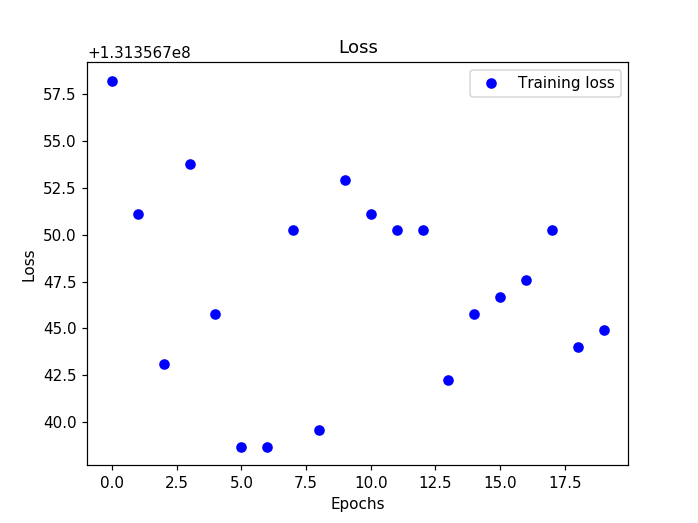

In [49]:
loss = autoencoder_train.history['loss']
epochs_plot = range(epochs)
plt.figure(2)
plt.plot(epochs_plot, loss, 'bo', label='Training loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
output.shape

(360, 5)